In [1]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import acquire
import prepare
import summarize
#from acquire import get_store_data
#from prepare import prep_store_data, split_store_data
#from summarize import df_summary

# Parametric Time-Series Modeling

1. Last
2. Sampling: pd.resample()
3. Simple Average: .mean()
4. Moving Average: .rolling(30).mean()
5. Holt's Linear Trend: with **statsmodels.api**
> tsa.seasonal_decompose()
>
> tsa.stattools.adfuller()
>
> statsmodels.tsa.api.Holt & .forecast
6. Custom: Using a static adjustment pd.date_range()
7. Evaluate: sklearn.metrics.mean_squared_error and math.sqrt(mse) for root mean squared error (RMSE)

## Acquire and Prepare

In [2]:
df = acquire.get_all_data(use_cache=True)

In [5]:
#df = prepare.prep_store_data(df)

In [3]:
def prep_store_data(df: pd.DataFrame) -> pd.DataFrame:
    return (df.assign(ds=pd.to_datetime(df.sale_date)).sort_values('ds')
            .assign(y=df.sale_amount * df.item_price)\
            .groupby(['ds'])['y'].sum().reset_index().set_index('ds'))

In [4]:
df = prep_store_data(df)
df.head()

,y
ds,
2013-01-01 00:00:00+00:00,73844.01
2013-01-02 00:00:00+00:00,73570.58
2013-01-03 00:00:00+00:00,78169.48
2013-01-04 00:00:00+00:00,84467.73
2013-01-05 00:00:00+00:00,87621.85


In [7]:
def split_store_data(df, train_prop=.66): 
    train_size = int(len(df) * train_prop)
    train, test = df[0:train_size].reset_index(), df[train_size:len(df)].reset_index()
    return train, test

In [8]:
train, test = split_store_data(df, train_prop=.66)

print('Observations: %d' % (len(df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 1826
Training Observations: 1205
Testing Observations: 621


In [9]:
train = train.set_index('ds')
test = test.set_index('ds')

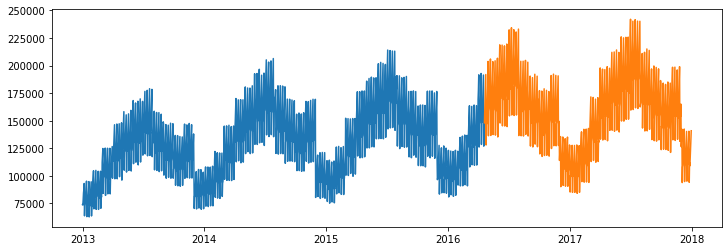

In [10]:
plt.figure(figsize=(12, 4))
plt.plot(train)
plt.plot(test)

In [11]:
def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train')
    plt.plot(test[target_vars], label='Test')

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()

In [12]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'metric', 'value'])
eval_df

,model_type,target_var,metric,value


In [13]:
def append_eval_df(model_type, target_vars, train = train, test = test):
    temp_eval_df = pd.concat([pd.DataFrame([[model_type, i, 'mse', evaluate(target_var = i, 
                                                                            train = train, 
                                                                            test = test, 
                                                                            output=False)[0]],
                                            [model_type, i, 'rmse', evaluate(target_var = i, 
                                                                             train = train, 
                                                                             test = test, 
                                                                             output=False)[1]]],
                                           columns=['model_type', 'target_var', 'metric', 'value']) 
                              for i in target_vars], ignore_index=True)
    return eval_df.append(temp_eval_df, ignore_index=True)

In [14]:
yhat = pd.DataFrame(test.y)

In [18]:
yhat['y'] = int(train.y[-1:])

In [20]:
yhat.min() == yhat.max()

y    True
dtype: bool

y -- MSE: 1218453415.13 RMSE: 34906.35


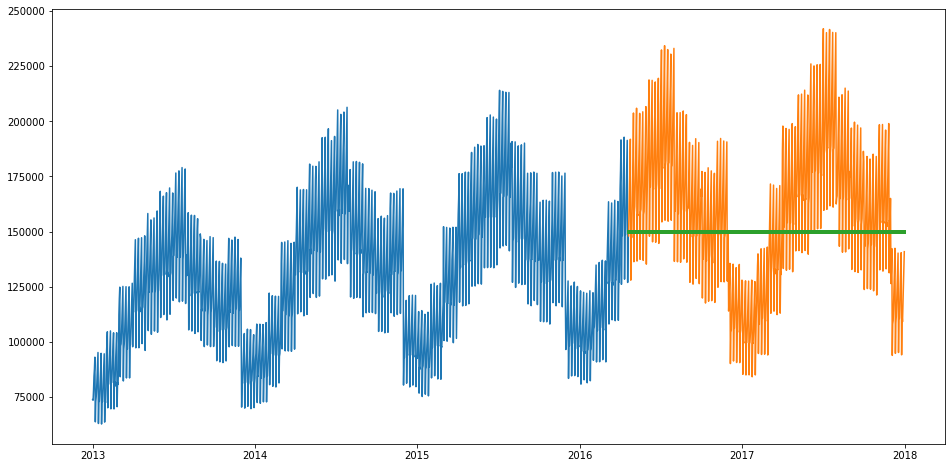

In [21]:
plot_and_eval(target_vars='y', train = train, test = test)

In [23]:
eval_df = append_eval_df(model_type = 'last_observed_value', target_vars=['y'], train = train, test = test)


In [24]:
eval_df

,model_type,target_var,metric,value
0,last_observed_value,y,mse,1.218453e+09
1,last_observed_value,y,rmse,3.490635e+04


## Simple Average

In [25]:
yhat['y'] = train.y.mean()

y -- MSE: 2005573188.71 RMSE: 44783.63


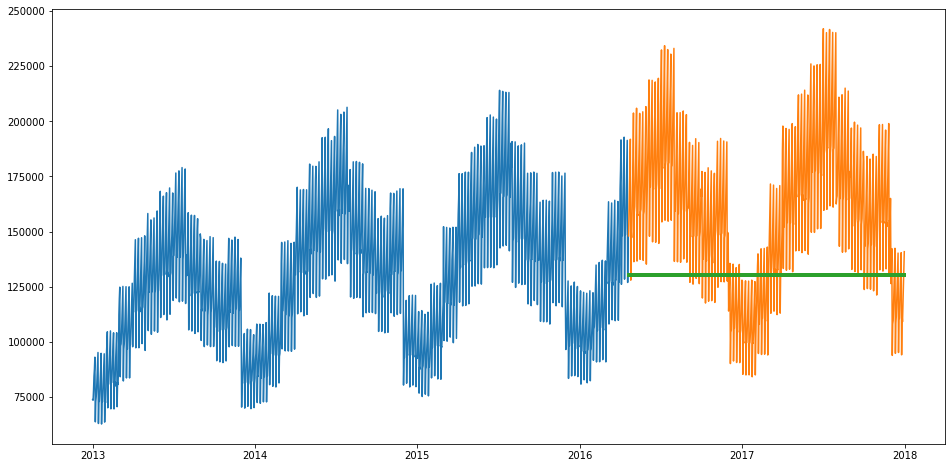

In [27]:
target_vars = ['y']
plot_and_eval(target_vars, train = train, test = test)

In [28]:
eval_df = append_eval_df(model_type='simple_average', target_vars=['y'], train = train, test = test)
eval_df

,model_type,target_var,metric,value
0,last_observed_value,y,mse,1.218453e+09
1,last_observed_value,y,rmse,3.490635e+04
2,simple_average,y,mse,2.005573e+09
3,simple_average,y,rmse,4.478363e+04


## Moving Average

In [29]:
periods = 30
yhat['y'] = train.y.rolling(periods).mean().iloc[-1]

y -- MSE: 1190931799.27 RMSE: 34509.88


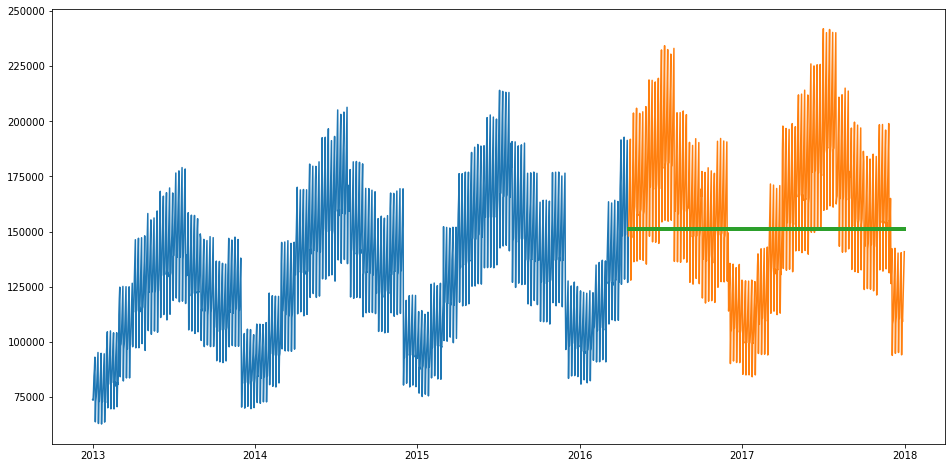

In [30]:
plot_and_eval(target_vars, train = train, test = test)

In [32]:
eval_df = append_eval_df(model_type='moving_average', target_vars=['y'], train = train, test = test)
eval_df

,model_type,target_var,metric,value
0,last_observed_value,y,mse,1.218453e+09
1,last_observed_value,y,rmse,3.490635e+04
2,simple_average,y,mse,2.005573e+09
3,simple_average,y,rmse,4.478363e+04
4,moving_average,y,mse,1.190932e+09
5,moving_average,y,rmse,3.450988e+04
6,moving_average,y,mse,1.190932e+09
7,moving_average,y,rmse,3.450988e+04


y -- MSE: 1190931799.27 RMSE: 34509.88


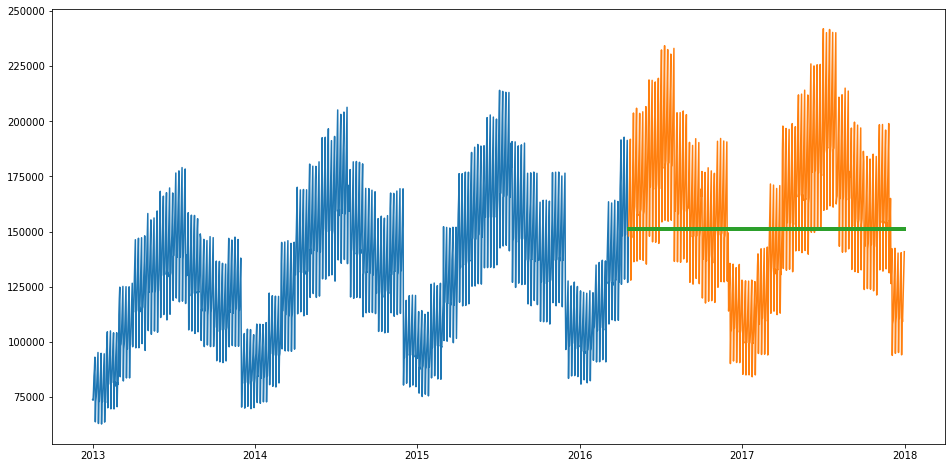


rolling averge period: 1

item sales

MSE:  1218439218.4223528
RMSE: 34906.14871942124

rolling averge period: 4

item sales

MSE:  1108123460.1111584
RMSE: 33288.48840231647

rolling averge period: 12

item sales

MSE:  1109636561.8966641
RMSE: 33311.207751996386

rolling averge period: 26

item sales

MSE:  1134206108.411572
RMSE: 33677.976608038254

rolling averge period: 52

item sales

MSE:  1334512552.9426928
RMSE: 36530.980727906724

rolling averge period: 104

item sales

MSE:  2187531052.7291975
RMSE: 46771.04930113497


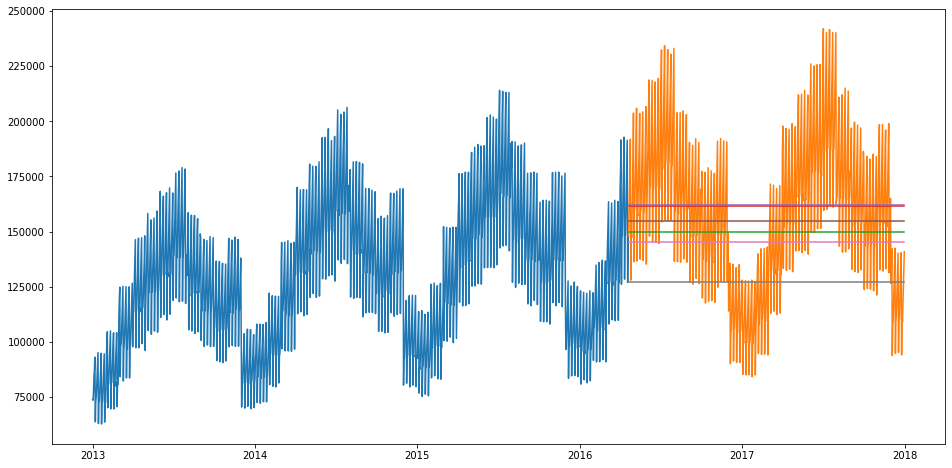

In [33]:
periods = 30
yhat['y'] = train.y.rolling(periods).mean().iloc[-1]

plot_and_eval(target_vars, train, test)
eval_df = append_eval_df(model_type='moving_average', target_vars=['y'], train = train, test = test)

plt.figure(figsize=(16, 8))
plt.plot(train[target_vars],label='Train')
plt.plot(test[target_vars], label='Test')
period_vals = [1, 4, 12, 26, 52, 104]
for p in period_vals:
    yhat['y'] = train.y.rolling(p).mean().iloc[-1]
    plt.plot(yhat.y)
    print('\nrolling averge period:',p)
    print('\nitem sales\n')
    evaluate('y', train = train, test = test)

## Holt's Linear Trend

y 



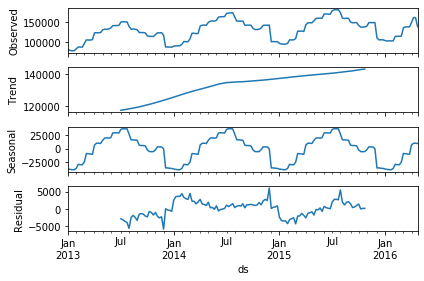

In [34]:
import statsmodels.api as sm

target_vars = ['y']
for var in target_vars:
    print(var,'\n')
    _ = sm.tsa.seasonal_decompose(train[var].resample('W').mean()).plot()
    plt.show()

y -- MSE: 1497511048.56 RMSE: 38697.69


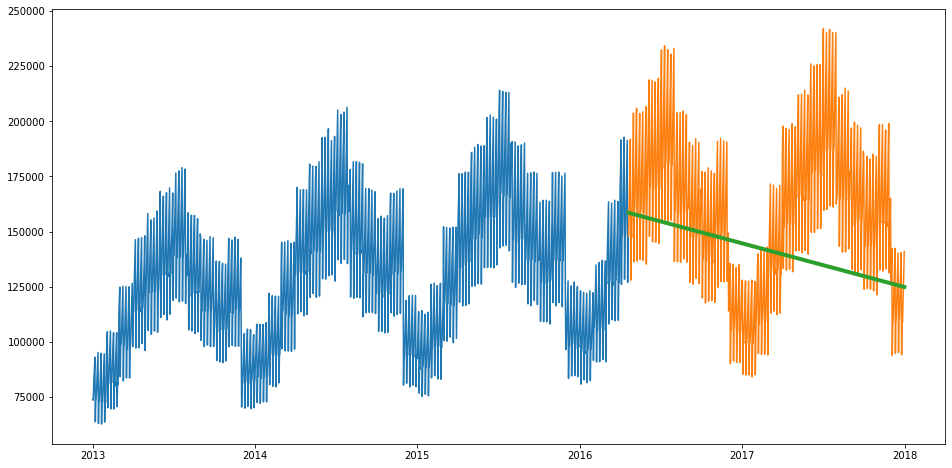

In [35]:
# Fit Basic Holt's Linear Trend Model

from statsmodels.tsa.api import Holt

model = Holt(train['y']).fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)
yhat['y'] = pd.DataFrame(model.forecast(test['y'].shape[0]), columns=['y'])

plot_and_eval(target_vars, train, test)
eval_df = append_eval_df(model_type='holts_linear_trend', target_vars=['y'], train = train, test = test)

y -- MSE: 5042237943.85 RMSE: 71008.72


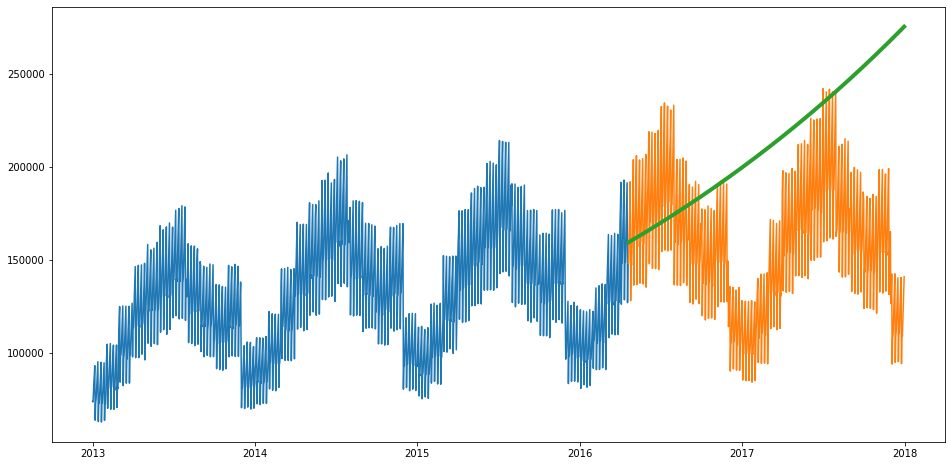

In [36]:
# Fit Holt's Exponential Linear Trend

model = Holt(train['y'], exponential=True).fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)
yhat['y'] = pd.DataFrame(model.forecast(test['y'].shape[0]), columns=['y'])

plot_and_eval(target_vars, train, test)
eval_df = append_eval_df(model_type='holts_exponential_trend', target_vars=['y'], train = train, test = test)

## Predicting Based on the Previous Cycle

In [37]:
yhat = train['2015-04-20':'2016-04-19'] + train['2013-04-20':'2016-04-19'].diff(365).mean()
# set the date (index) to be represent the date for our predictions
yhat.index = pd.date_range('2016-04-20', periods=len(yhat))
yhat.tail()

,y
2017-04-16,180925.583981
2017-04-17,189455.553981
2017-04-18,202284.273981
2017-04-19,137870.703981
2017-04-20,160562.853981


y -- MSE: 838024000.22 RMSE: 28948.64


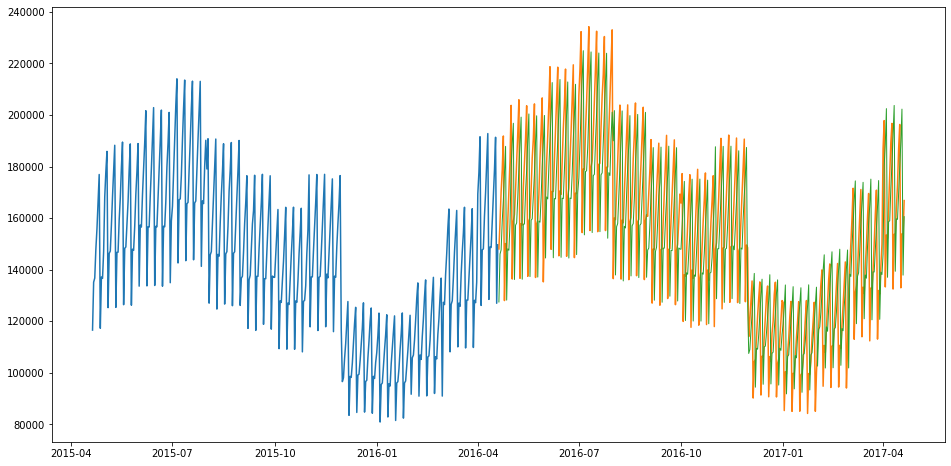

In [38]:
train1 = train['2015-04-20':'2016-04-19']
test1 = test['2016-04-20':'2017-04-20']

plot_and_eval(target_vars, train = train1, test = test1, linewidth=1)
eval_df = append_eval_df(model_type='previous_year', target_vars=['y'], train = train1, test = test1)

Text(0, 0.5, 'RMSE')

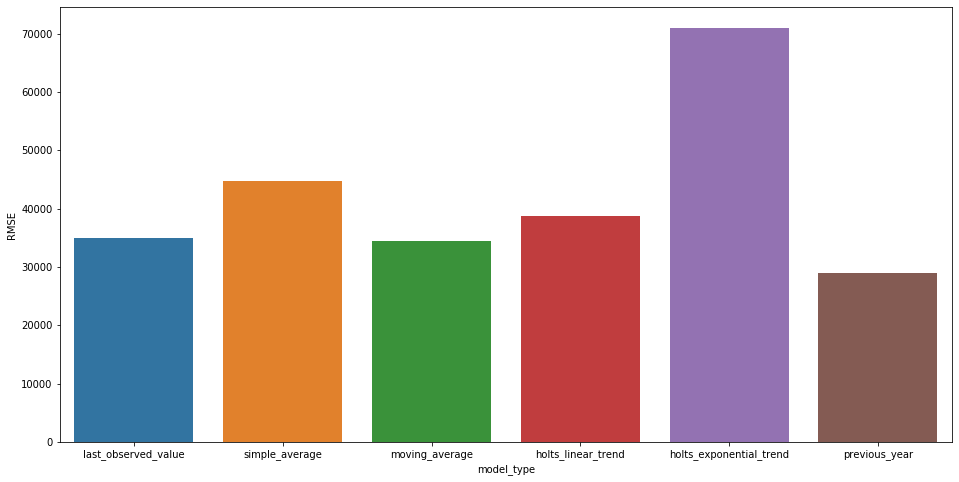

In [39]:
x = eval_df[eval_df.metric == 'rmse']['model_type']
y = eval_df[eval_df.metric == 'rmse']['value']
plt.figure(figsize=(16, 8))
sns.barplot(x, y)
plt.ylabel('RMSE')